In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
from sklearn.linear_model import RidgeCV,LassoCV,LinearRegression,ElasticNet
from sklearn.ensemble import AdaBoostRegressor,GradientBoostingRegressor,BaggingRegressor,RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score,KFold
from sklearn.metrics import r2_score
from sklearn.feature_selection import chi2,SelectKBest
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=14,16

In [0]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

In [0]:
train_set = pd.read_excel('Data_Train.xlsx')
test_set = pd.read_excel('Test_set.xlsx')
whole_dataset = train_set.append(test_set)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [0]:
whole_dataset

,Additional_Info,Airline,Arrival_Time,Date_of_Journey,Dep_Time,Destination,Duration,Price,Route,Source,Total_Stops
0,No info,IndiGo,01:10 22 Mar,24/03/2019,22:20,New Delhi,2h 50m,3897.0,BLR → DEL,Banglore,non-stop
1,No info,Air India,13:15,1/05/2019,05:50,Banglore,7h 25m,7662.0,CCU → IXR → BBI → BLR,Kolkata,2 stops
2,No info,Jet Airways,04:25 10 Jun,9/06/2019,09:25,Cochin,19h,13882.0,DEL → LKO → BOM → COK,Delhi,2 stops
3,No info,IndiGo,23:30,12/05/2019,18:05,Banglore,5h 25m,6218.0,CCU → NAG → BLR,Kolkata,1 stop
4,No info,IndiGo,21:35,01/03/2019,16:50,New Delhi,4h 45m,13302.0,BLR → NAG → DEL,Banglore,1 stop
...,...,...,...,...,...,...,...,...,...,...,...
2666,No info,Air India,20:25 07 Jun,6/06/2019,20:30,Banglore,23h 55m,NaN,CCU → DEL → BLR,Kolkata,1 stop
2667,No info,IndiGo,16:55,27/03/2019,14:20,Banglore,2h 35m,NaN,CCU → BLR,Kolkata,non-stop
2668,No info,Jet Airways,04:25 07 Mar,6/03/2019,21:50,Cochin,6h 35m,NaN,DEL → BOM → COK,Delhi,1 stop
2669,No info,Air India,19:15,6/03/2019,04:00,Cochin,15h 15m,NaN,DEL → BOM → COK,Delhi,1 stop


In [0]:
whole_dataset.dtypes

Additional_Info     object
Airline             object
Arrival_Time        object
Date_of_Journey     object
Dep_Time            object
Destination         object
Duration            object
Price              float64
Route               object
Source              object
Total_Stops         object
dtype: object

In [0]:
whole_dataset.isnull().sum()

Additional_Info       0
Airline               0
Arrival_Time          0
Date_of_Journey       0
Dep_Time              0
Destination           0
Duration              0
Price              2671
Route                 1
Source                0
Total_Stops           1
dtype: int64

In [0]:
whole_dataset.dropna(subset=['Total_Stops'],inplace=True)

**Feature Genenration**

In [0]:
#On Arrival_time Column we will extract Hours and minute
whole_dataset['Arrival_Time'] = whole_dataset['Arrival_Time'].str.split(' ').str[0]
whole_dataset['Arrival_Hour'] = whole_dataset['Arrival_Time'].str.split(':').str[0].astype(int)
whole_dataset['Arrival_Minute'] = whole_dataset['Arrival_Time'].str.split(':').str[1].astype(int)

In [0]:
#On Date_of_Journey Column we will extract Day,Month and Year of journey
whole_dataset['Day of Journey'] = pd.DatetimeIndex(whole_dataset['Date_of_Journey']).day
whole_dataset['Month of Journey'] = pd.DatetimeIndex(whole_dataset['Date_of_Journey']).month
whole_dataset['Year of Journey'] = pd.DatetimeIndex(whole_dataset['Date_of_Journey']).year

In [0]:
#On Dep_time Column we will extract Hours and minute
whole_dataset['Dep_Hour'] = whole_dataset['Dep_Time'].str.split(':').str[0].astype(int)
whole_dataset['Dep_Minute'] = whole_dataset['Dep_Time'].str.split(':').str[1].astype(int)

In [0]:
#Converting Journey Duration in minutes
whole_dataset['Duration_in_minute']=whole_dataset['Duration'].replace({'h': '*60', 'm': '*1',' ':'+'}, regex=True).map(pd.eval).astype(int)

In [0]:
#Routes
whole_dataset['Route1'] = whole_dataset['Route'].str.split('→').str[0]
whole_dataset['Route2'] = whole_dataset['Route'].str.split('→').str[1]
whole_dataset['Route3'] = whole_dataset['Route'].str.split('→').str[2]
whole_dataset['Route4'] = whole_dataset['Route'].str.split('→').str[3]
whole_dataset['Route5'] = whole_dataset['Route'].str.split('→').str[4]

In [0]:
whole_dataset['Route1'].fillna("None",inplace=True)
whole_dataset['Route2'].fillna("None",inplace=True)
whole_dataset['Route3'].fillna("None",inplace=True)
whole_dataset['Route4'].fillna("None",inplace=True)
whole_dataset['Route5'].fillna("None",inplace=True)

In [0]:
#Extract total stop count from 'Total_stops' column
whole_dataset['Total_Stops'] = whole_dataset['Total_Stops'].replace('non-stop','0 stop')
whole_dataset['No_of_Stops'] = whole_dataset['Total_Stops'].str.split(' ').str[0]

In [0]:
whole_dataset['No_of_Stops'] = whole_dataset['No_of_Stops'].astype(int)

In [0]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
catgorical_features = ['Additional_Info','Airline','Source','Destination','Route1','Route2','Route3','Route4','Route5']
whole_dataset[catgorical_features] = whole_dataset[catgorical_features].apply(le.fit_transform)

In [0]:
whole_dataset.dtypes

Additional_Info         int64
Airline                 int64
Arrival_Time           object
Date_of_Journey        object
Dep_Time               object
Destination             int64
Duration               object
Price                 float64
Route                  object
Source                  int64
Total_Stops            object
Arrival_Hour            int64
Arrival_Minute          int64
Day of Journey          int64
Month of Journey        int64
Year of Journey         int64
Dep_Hour                int64
Dep_Minute              int64
Duration_in_minute      int64
Route1                  int64
Route2                  int64
Route3                  int64
Route4                  int64
Route5                  int64
No_of_Stops             int64
dtype: object

In [0]:
whole_dataset = whole_dataset[['Additional_Info','Airline','Source','Destination','Price','Route1','Route2','Route3','Route4','Route5','Arrival_Hour','Arrival_Minute','Dep_Hour','Dep_Minute','Day of Journey',
                               'Month of Journey','Year of Journey','Duration_in_minute','No_of_Stops']]

In [0]:
whole_dataset

,Additional_Info,Airline,Source,Destination,Price,Route1,Route2,Route3,Route4,Route5,Arrival_Hour,Arrival_Minute,Dep_Hour,Dep_Minute,Day of Journey,Month of Journey,Year of Journey,Duration_in_minute,No_of_Stops
0,8,3,0,5,3897.0,0,13,30,13,5,1,10,22,20,24,3,2019,170,0
1,8,1,3,0,7662.0,2,25,1,3,5,13,15,5,50,5,1,2019,445,2
2,8,4,2,1,13882.0,3,32,4,5,5,4,25,9,25,6,9,2019,1140,2
3,8,3,3,0,6218.0,2,34,3,13,5,23,30,18,5,5,12,2019,325,1
4,8,3,0,5,13302.0,0,34,8,13,5,21,35,16,50,3,1,2019,285,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2666,8,1,3,0,NaN,2,14,3,13,5,20,25,20,30,6,6,2019,1435,1
2667,8,3,3,0,NaN,2,5,30,13,5,16,55,14,20,27,3,2019,155,0
2668,8,4,2,1,NaN,3,7,6,13,5,4,25,21,50,3,6,2019,395,1
2669,8,1,2,1,NaN,3,7,6,13,5,19,15,4,0,3,6,2019,915,1


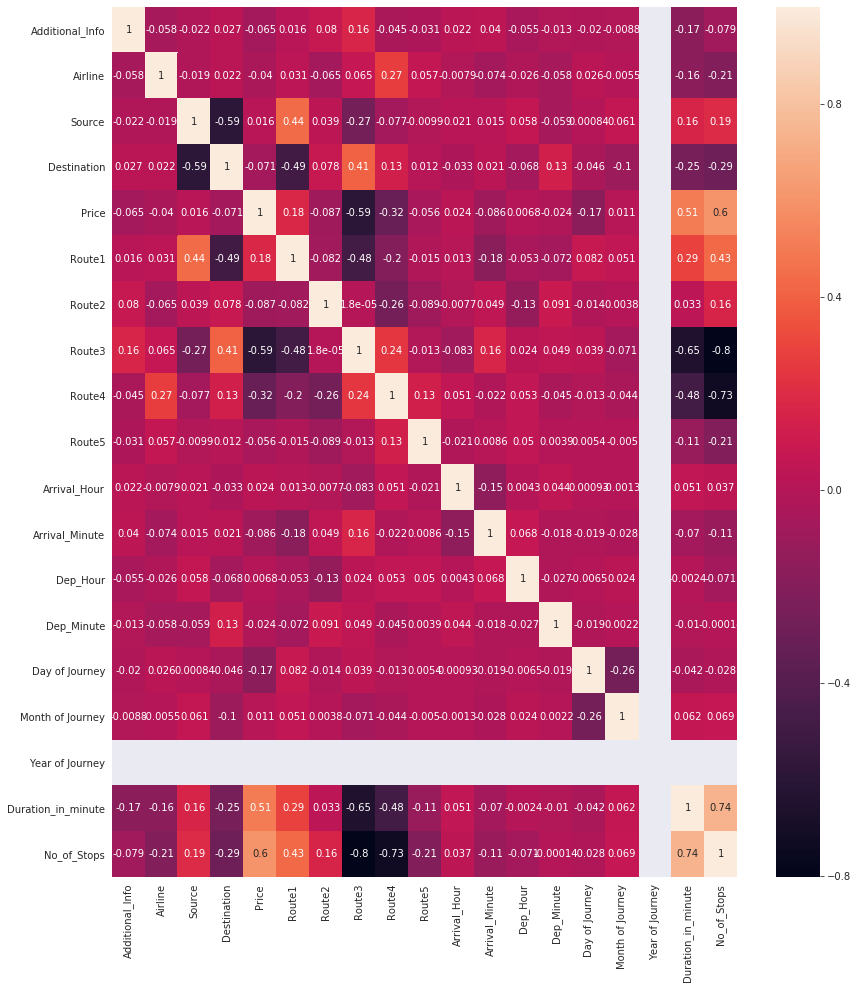

In [0]:
sns.heatmap(whole_dataset.corr(),annot=True,fmt='.2g')

In [0]:
df_train = whole_dataset[0:10682]
df_test = whole_dataset[10682:]
train_feature = df_train.drop(['Price'],axis=1)
train_price = df_train.Price
df_test = df_test.drop(['Price'],axis=1)

In [0]:
train_feature.shape

(10682, 18)

In [0]:
best_feature = SelectKBest(score_func=chi2,k=10)
fit = best_feature.fit(train_feature,train_price)
df_score = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(train_feature.columns)
feature_scores = pd.concat([dfcolumns,df_score],axis=1)
feature_scores.columns = ['Feature','Score']
print(feature_scores.nlargest(10,'Score'))

               Feature         Score
16  Duration_in_minute  3.344725e+06
6               Route3  1.072414e+05
12          Dep_Minute  6.839028e+04
5               Route2  5.076259e+04
10      Arrival_Minute  5.044355e+04
13      Day of Journey  2.707437e+04
9         Arrival_Hour  1.895928e+04
3          Destination  1.551793e+04
1              Airline  1.405766e+04
11            Dep_Hour  1.105831e+04


In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_train,X_val,y_train,y_val = train_test_split(train_feature,train_price,test_size=0.33,random_state=42)

In [0]:
kfold = KFold(n_splits=50,shuffle=True,random_state=42)

In [0]:
def cv_rmse(model):
  cv_score = np.sqrt(-cross_val_score(model,train_feature,train_price,scoring='neg_mean_squared_error',cv=kfold))
  return(cv_score)

In [0]:
lin = LinearRegression()
base_model = make_pipeline(RobustScaler(),lin).fit(X_train,y_train)
print(cv_rmse(base_model).mean())

3238.43553111191


In [0]:
r2_score(y_val,base_model.predict(X_val))

0.521615105277303

In [0]:
Adb = make_pipeline(RobustScaler(),AdaBoostRegressor()).fit(X_train,y_train)
gb = make_pipeline(RobustScaler(),GradientBoostingRegressor()).fit(X_train,y_train)
br = make_pipeline(RobustScaler(),BaggingRegressor()).fit(X_train,y_train)
dtr = make_pipeline(RobustScaler(),DecisionTreeRegressor()).fit(X_train,y_train)
model_names = ["AdaBoost Regressor","Gradient Boosting Regressor","Bagging Regressor","Decision Tree Regressor"]
models = [Adb,gb,br,dtr]
for name,model in zip(model_names,models):
  print("RMSE score for ",name," is : ",cv_rmse(model).mean())
 

RMSE score for  AdaBoost Regressor  is :  3873.1239683740478
RMSE score for  Gradient Boosting Regressor  is :  1865.9665585279947
RMSE score for  Bagging Regressor  is :  1520.1052619197371
RMSE score for  Decision Tree Regressor  is :  1951.7007809117758


In [0]:
estimators = [150,200,400,700,800]
for name,model in zip(model_names,models):
  model.fit(X_train,y_train)
  pred_views = model.predict(X_val)
  print("R^2 Score for",name,"is : ",r2_score(y_val,pred_views))

R^2 Score for AdaBoost Regressor is :  0.3424158781770903
R^2 Score for Gradient Boosting Regressor is :  0.8437304796839036
R^2 Score for Bagging Regressor is :  0.8457280983668695
R^2 Score for Decision Tree Regressor is :  0.7766699966756069


In [0]:
xgb = XGBRegressor()
parameters = { 
                'objective':['reg:linear'],
                'learning_rate': [0.045,0.05,0.06], 
                'max_depth': [4,5],
                'min_child_weight': [4,6],
                'silent': [1],
                'subsample': [0.6,0.7],
                'colsample_bytree': [0.7,0.8],
                'n_estimators': [300,450,650],
                'reg_alpha':[0.001]
              }

xgb_grid = GridSearchCV(xgb,
                          parameters,
                          scoring='neg_mean_squared_error', #this line can be commented to use XGB's default metric
                          cv = 4,
                          n_jobs = -1,
                          verbose=True)

In [0]:
xgb_model = make_pipeline(RobustScaler(),xgb_grid).fit(X_train,y_train)

Fitting 4 folds for each of 144 candidates, totalling 576 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 13.9min
[Parallel(n_jobs=-1)]: Done 576 out of 576 | elapsed: 18.5min finished
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [0]:
print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

-2643153.0848898315
{'colsample_bytree': 0.7, 'learning_rate': 0.06, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 650, 'objective': 'reg:linear', 'reg_alpha': 0.001, 'silent': 1, 'subsample': 0.7}


In [0]:
xgb_final = XGBRegressor(max_depth=5,learning_rate=0.06,n_estimators=650,objective='reg:linear',colsample_bytree=0.7,reg_alpha=0.001,subsample=0.7,min_child_weight=4)
xgb_pipeline = make_pipeline(RobustScaler(),xgb_final).fit(X_train,y_train)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[08:55:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [0]:
xgb_pred = xgb_pipeline.predict(X_val)
print("R^2 Score for XGBRegressor is : ",r2_score(y_val,xgb_pred))

R^2 Score for XGBRegressor is :  0.902909427237827


In [0]:
print("RMSE for XGB Regressor : ",cv_rmse(xgb_pipeline).mean())

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[09:01:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[09:01:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[09:01:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[09:02:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[09:02:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[09:02:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[09:02:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[09:02:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[09:02:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[09:02:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[09:02:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[09:03:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[09:03:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[09:03:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[09:03:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[09:03:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[09:03:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[09:03:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[09:03:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[09:03:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[09:04:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[09:04:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[09:04:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[09:04:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[09:04:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[09:04:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[09:04:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[09:04:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[09:04:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[09:05:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[09:05:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[09:05:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[09:05:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[09:05:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[09:05:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[09:05:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[09:05:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[09:05:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[09:06:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[09:06:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[09:06:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[09:06:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[09:06:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[09:06:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[09:06:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[09:06:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[09:07:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[09:07:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[09:07:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[09:07:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE for XGB Regressor :  1341.6151357724063


Text(0, 0.5, 'rmse')

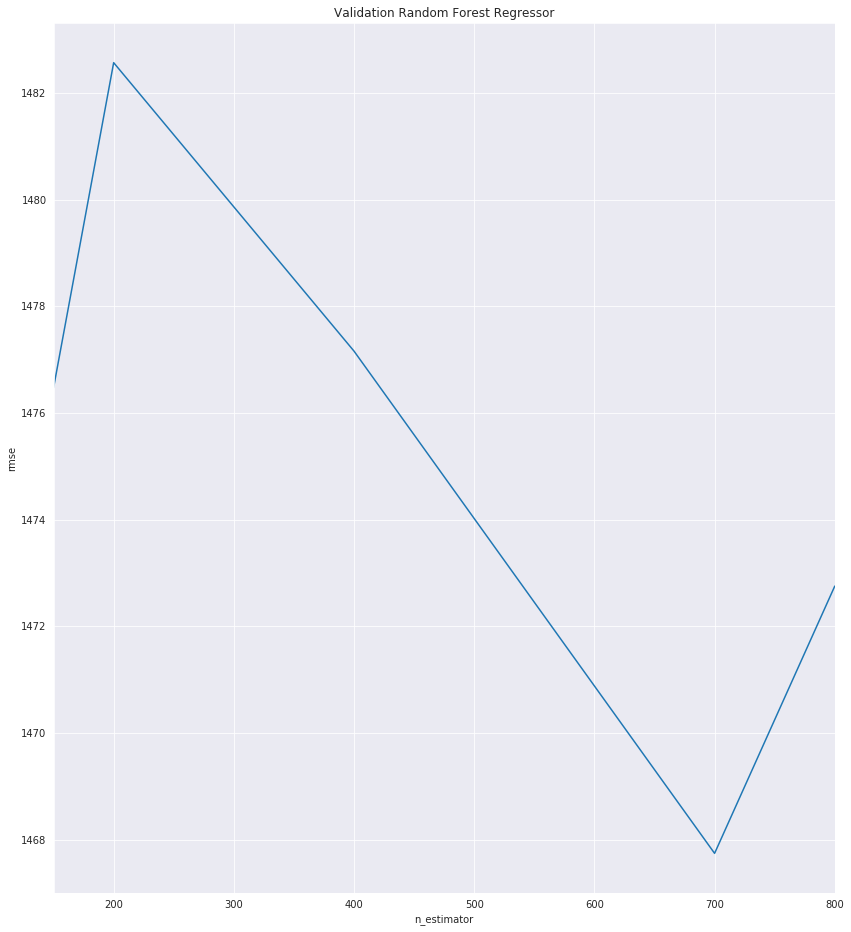

In [0]:
cv_score = [cv_rmse(RandomForestRegressor(n_estimators = estimator)).mean() for estimator in estimators]
cv_gb = pd.Series(cv_score , index = estimators)
cv_gb.plot(title = "Validation Random Forest Regressor")
plt.xlabel("n_estimator")
plt.ylabel("rmse")

In [0]:
rf_model = make_pipeline(RobustScaler(),RandomForestRegressor(n_estimators=700)).fit(X_train,y_train)
rf_model.fit(X_train,y_train)
print("R^2 Score for Random Forest Regressor : ",r2_score(y_val,rf_model.predict(X_val)))

R^2 Score for Random Forest Regressor :  0.8671280006854217


In [0]:
xgb_predictions = xgb_pipeline.predict(train_feature)
comparison = pd.DataFrame({"Actual Price":train_price,"Predicted Price":xgb_predictions,"Diffirence":abs(train_price-xgb_predictions)})
comparison.to_csv('Comparison.csv',index=False)